In [1]:
!pip install --user git+https://github.com/kilean20/pyTorchTemplate.git

  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-5s1zeyb1
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-5s1zeyb1
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6496 sha256=a5cdefccf03bdee4161f1f454571f5a150fe8d029483dcf00fc04b2f62a27fd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-la1i0dun/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate


In [2]:
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy

In [3]:
import pyTorchTemplate as ptt
device = ptt.device

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [5]:
nsample = 16
nensemble = 16
nModel = 16
nodes = [1,512,512,1]

# Targets

In [6]:
from scipy.special import airy

def func(x):
  return np.sin(np.pi*4*x)

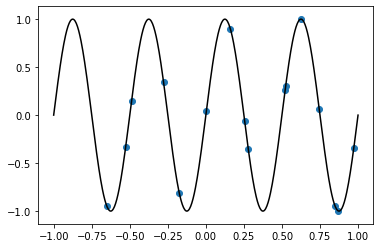

In [7]:
train_input = (np.random.rand(nsample)*2.0-1.0).reshape(-1,1).astype(np.float32)
train_output = func(train_input)

test_input = np.linspace(-1, 1, 512).reshape(-1,1).astype(np.float32)
test_output = func(test_input)

train_data_loader = torch.utils.data.DataLoader(list(zip(train_input,train_output)), batch_size=nsample, shuffle=False)
test_data_loader = torch.utils.data.DataLoader(list(zip(test_input,test_output)), batch_size=512, shuffle=False) 

for x,y in test_data_loader:
    plt.plot(x,y,c='k')
    
for x,y in train_data_loader:
    plt.scatter(x,y)        

# GP

In [8]:
kernel = C(0.2, (1e-3, 1e3)) * RBF(1, (1e-2, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [9]:
gp.score(train_input,train_output), gp.score(test_input,test_output)

(-0.032939065415820146, -1.2522545222992676e-09)

In [10]:
gp.fit(train_input, train_output)
gp.kernel_

/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


3.29**2 * RBF(length_scale=0.239)

In [11]:
gp.score(train_input,train_output), gp.score(test_input,test_output)

(0.9999999999996159, 0.47699150140980073)

In [12]:
gp_predict_mean, gp_predict_std = gp.predict(test_input, return_std=True)
gp_predict_mean = gp_predict_mean.reshape(-1)

/usr/common/software/pytorch/v1.4.0/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


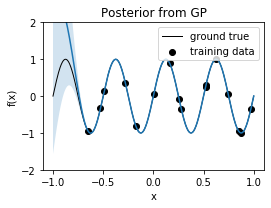

In [13]:
plt.figure(figsize=(4,3))

plt.plot(test_input,test_output,label='ground true',lw=1,c='k')
plt.fill_between(test_input[:,0], 
                 gp_predict_mean + 1.96*gp_predict_std, 
                 gp_predict_mean - 1.96*gp_predict_std, alpha=0.2)
plt.plot(test_input,gp_predict_mean)
plt.scatter(train_input,train_output,c='k',label='training data')

# plt.legend()
plt.title('Posterior from GP')
plt.xlabel('x');
plt.ylabel('f(x)');
plt.ylim(-2,2)
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig('GP.png',dpi=180)

# NNensemble (ReLU)

In [14]:
def test(model,test_data_loader):
    model.eval()
    loss = 0 
    for x, y in test_data_loader:
        x = x.to(device)
        y_pred = model(x)
        loss += torch.nn.MSELoss()(y_pred, y.to(device)).item()
    return loss/len(test_data_loader)

In [15]:
model_outputs = [0]*nModel
model_test_outputs = [0]*nModel
Hist = [0]*nModel

for i in range(nModel):
    model = ptt.FCNN(nodes=nodes, activation=torch.nn.ReLU(inplace=True),dropout_p=0)
    old_best_loss = 10
    for j in range(8):
        mode,hist = ptt.train_supervised(model, 1.0e-2,1000,
                                         train_data_loader,
                                         criterion=torch.nn.MSELoss(),
                                         old_best_loss = old_best_loss,
                                         dispHead = 0, dispTail = 0)

        newloss = test(model,test_data_loader)
        print(j,newloss)

        if newloss < old_best_loss:
            old_best_loss = newloss
            final_model = copy(model)
            final_hist  = copy(hist)

        if newloss < 2e-3:
            break

    model = final_model
    hist = final_hist
    mode,hist = ptt.train_supervised(model,2.0e-4,2000,
                                     train_data_loader,
                                     old_hist = hist,
                                     criterion=torch.nn.MSELoss(),
                                     old_best_loss = newloss,
                                     dispHead = 0, dispTail = 0)
    Hist[i]=hist
    model_outputs[i] = []
    model_test_outputs[i] = []

    model.eval()  
    with torch.no_grad():
        for x,y in train_data_loader:
            surrogate_y = model(x.to(device))
            model_outputs[i] = model_outputs[i] + surrogate_y.cpu().tolist()

        for x,y in test_data_loader:  
            surrogate_y = model(x.to(device))
            model_test_outputs[i] = model_test_outputs[i] + surrogate_y.tolist()

0 1.34831702709198train loss = 0.002384
1 1.2237181663513184ain loss = 0.000454
2 1.2792396545410156ain loss = 0.000070
3 1.9479641914367676ain loss = 0.000089
4 1.5810692310333252ain loss = 0.000061
5 1.653711199760437rain loss = 0.000060
6 1.7916251420974731ain loss = 0.000060
7 2.066415786743164rain loss = 0.000064
0 1.2704777717590332ain loss = 0.0018700
1 1.000643014907837rain loss = 0.001099
2 1.0224623680114746ain loss = 0.000011
3 0.998790979385376rain loss = 0.000009
4 0.9731016755104065ain loss = 0.000009
5 0.826680600643158rain loss = 0.004519
6 0.8382417559623718ain loss = 0.000018
7 0.7919831275939941ain loss = 0.000016
0 1.3612571954727173ain loss = 0.0019314
1 1.35121488571167train loss = 0.001843
2 1.353112816810608rain loss = 0.001806
3 1.2682381868362427ain loss = 0.001119
4 1.1659173965454102ain loss = 0.000354
5 1.146283745765686rain loss = 0.000129
6 1.0752065181732178ain loss = 0.000019
7 1.0700724124908447ain loss = 0.000019
0 1.2238794565200806ain loss = 0.05063

No handles with labels found to put in legend.


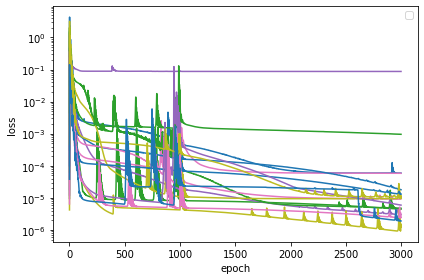

In [16]:
for hist in Hist:
  ptt.plot.history(hist)
plt.legend(loc = 'upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.tight_layout()
plt.savefig('NNensemble_ReLU_hist.png',dpi=180)

In [17]:
model_test_outputs = np.array(model_test_outputs)
model_test_outputs_mean = np.mean(model_test_outputs,axis=0).reshape(-1,1)
model_test_outputs_std  = np.std(model_test_outputs,axis=0).reshape(-1,1)

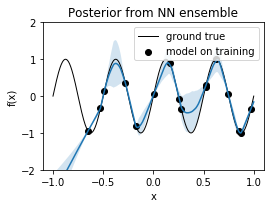

In [18]:
plt.figure(figsize=(4,3))

plt.plot(test_input,test_output,label='ground true',lw=1,c='k')
plt.fill_between(test_input[:,0], 
                 model_test_outputs_mean[:,0] + 1.96*model_test_outputs_std[:,0], 
                 model_test_outputs_mean[:,0] - 1.96*model_test_outputs_std[:,0], alpha=0.2)
plt.plot(test_input,model_test_outputs_mean)
plt.scatter(train_input,train_output,c='k',label='model on training')
plt.xlabel('x');
plt.ylabel('f(x)');
plt.ylim(-2,2)
plt.legend(loc = 'upper right')
plt.title('Posterior from NN ensemble')
plt.tight_layout()
plt.savefig('NNensemble_ReLU.png',dpi=180)

# NNensemble (CELU)

In [19]:
odel_outputs = [0]*nModel
model_test_outputs = [0]*nModel
Hist = [0]*nModel

for i in range(nModel):
    model = ptt.FCNN(nodes=nodes, activation=torch.nn.CELU(inplace=True),dropout_p=0)
    old_best_loss = 10
    for j in range(8):
        mode,hist = ptt.train_supervised(model, 1.0e-2, 1000,
                                         train_data_loader,
                                         criterion=torch.nn.MSELoss(),
                                         old_best_loss = old_best_loss,
                                         dispHead = 0, dispTail = 0)

        newloss = test(model,test_data_loader)
        print(j,newloss)

        if newloss < old_best_loss:
            old_best_loss = newloss
            final_model = copy(model)
            final_hist  = copy(hist)

        if newloss < 2e-3:
            break

    model = final_model
    hist = final_hist
    mode,hist = ptt.train_supervised(model,2.0e-4,2000,
                                     train_data_loader,
                                     old_hist = hist,
                                     criterion=torch.nn.MSELoss(),
                                     old_best_loss = newloss,
                                     dispHead = 0, dispTail = 0)
    Hist[i]=hist
    model_outputs[i] = []
    model_test_outputs[i] = []

    model.eval()  
    with torch.no_grad():
        for x,y in train_data_loader:
            surrogate_y = model(x.to(device))
            model_outputs[i] = model_outputs[i] + surrogate_y.cpu().tolist()

        for x,y in test_data_loader:  
            surrogate_y = model(x.to(device))
            model_test_outputs[i] = model_test_outputs[i] + surrogate_y.tolist()

0 2.23740291595459train loss = 0.075919
1 0.4810898005962372ain loss = 0.192403
2 0.8788649439811707ain loss = 0.000877
3 0.28443804383277893in loss = 0.000124
4 0.15128785371780396in loss = 0.000249
5 0.10076068341732025in loss = 0.000174
6 0.2721668481826782ain loss = 0.000015
7 0.6020200252532959ain loss = 0.000080
0 1.2457126379013062ain loss = 0.1128766
1 1.3102132081985474ain loss = 0.046650
2 0.9067168235778809ain loss = 0.000138
3 0.8758500814437866ain loss = 0.000066
4 1.0573781728744507ain loss = 0.001442
5 0.6479547619819641ain loss = 0.000027
6 1.5249922275543213ain loss = 0.001899
7 1.3270095586776733ain loss = 0.001846
0 1.7900519371032715ain loss = 0.0734534
1 0.8749130368232727ain loss = 0.000747
2 0.7734484672546387ain loss = 0.000128
3 0.5195819139480591ain loss = 0.000025
4 0.723308265209198rain loss = 0.000019
5 1.2635289430618286ain loss = 0.000009
6 0.552578330039978rain loss = 0.000021
7 0.9375196695327759ain loss = 0.000009
0 2.904608726501465rain loss = 0.08833

No handles with labels found to put in legend.


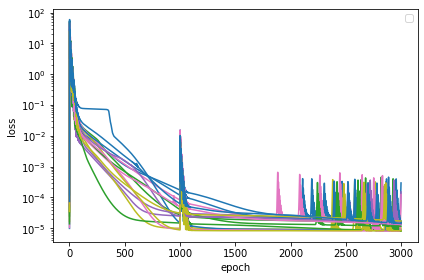

In [20]:
for hist in Hist:
  ptt.plot.history(hist)
plt.legend(loc = 'upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.tight_layout()
plt.savefig('NNensemble_CELU_hist.png',dpi=180)

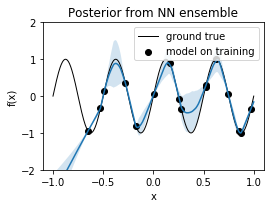

In [21]:
plt.figure(figsize=(4,3))

plt.plot(test_input,test_output,label='ground true',lw=1,c='k')
plt.fill_between(test_input[:,0], 
                 model_test_outputs_mean[:,0] + 1.96*model_test_outputs_std[:,0], 
                 model_test_outputs_mean[:,0] - 1.96*model_test_outputs_std[:,0], alpha=0.2)
plt.plot(test_input,model_test_outputs_mean)
plt.scatter(train_input,train_output,c='k',label='model on training')
plt.xlabel('x');
plt.ylabel('f(x)');
plt.ylim(-2,2)
plt.legend(loc = 'upper right')
plt.title('Posterior from NN ensemble')
plt.tight_layout()
plt.savefig('NNensemble_CELU.png',dpi=180)